# Benchmarking PValue Behavior

Now that we have the multi-view trees developed, we want to analyze the pvalue behavior under various data generating-models and make sure the null and alternative hypotheses are correctly modeled.

In [1]:
%load_ext autoreload
%autoreload 2

In [38]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import expit
from sklearn.datasets import (
    make_blobs,
    make_classification,
    make_sparse_spd_matrix,
    make_spd_matrix,
)
from sklearn.tree import DecisionTreeClassifier as skDecisionTreeClassifier

from sktree import HonestForestClassifier, RandomForestClassifier, RandomForestRegressor
from sktree.datasets.multiview import make_gaussian_mixture, make_joint_factor_model
from sktree.stats import (
    FeatureImportanceForestClassifier,
    FeatureImportanceForestRegressor,
    PermutationForestRegressor,
)
from sktree.tree import DecisionTreeClassifier, MultiViewDecisionTreeClassifier

seed = 12345
rng = np.random.default_rng(seed)

In [3]:
print("done")

done


In [4]:
max_features = "sqrt"
n_estimators = 500
n_jobs = -1
test_size = 0.2
max_fpr = 0.1

# Data-generating model with a copy of the feature-set

Here, we say X = (X1, X1), where X1 is a feature-set that may be informative of Y.

TODO: maybe vary max_features depending on the dimensionality of the original X1. E.g. if X1 is 100 dims, then X = (X1, X1) is now 200 dims but if you have sqrt, then you're going from 10 random samples of X1 dimensions to sqrt(200) samples of X1 dimensions "kind of".

In [34]:
n_samples = 200
noise_dims = 80
n_features = 100 - noise_dims
n_features_2 = 10000 - noise_dims

max_features = 0.3

n_repeats = 5

In [35]:
X, y = make_classification(
    n_samples=n_samples,
    n_features=1000,
    n_informative=10,
    n_redundant=5,
    n_repeated=0,
    n_classes=2,
    class_sep=2.0,
    flip_y=0.05,
    shuffle=False,
    random_state=seed,
)
n_features_ends = [20, X.shape[1]]
print(n_features_ends)
print(X.shape, np.sum(y) / n_samples)

X = np.hstack((X, X))
print(X.shape)

n_features_ends = [X.shape[1] // 2, X.shape[1]]
print(n_features_ends)

[20, 1000]
(200, 1000) 0.5
(200, 2000)
[1000, 2000]


In [42]:
est = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        tree_estimator=MultiViewDecisionTreeClassifier(
            feature_set_ends=n_features_ends,
            apply_max_features_per_feature_set=True,
        ),
        random_state=seed,
        honest_fraction=0.5,
        n_jobs=n_jobs,
    ),
    random_state=seed,
    test_size=test_size,
    permute_per_tree=False,
    sample_dataset_per_tree=False,
)

est_mv_old = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        tree_estimator=MultiViewDecisionTreeClassifier(
            feature_set_ends=n_features_ends,
            apply_max_features_per_feature_set=False,
        ),
        random_state=seed,
        honest_fraction=0.5,
        n_jobs=n_jobs,
    ),
    random_state=seed,
    test_size=test_size,
    permute_per_tree=False,
    sample_dataset_per_tree=False,
)

est_rf = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        tree_estimator=DecisionTreeClassifier(),
        # tree_estimator=skDecisionTreeClassifier(),
        random_state=seed,
        honest_fraction=0.5,
        n_jobs=n_jobs,
    ),
    random_state=seed,
    test_size=test_size,
    permute_per_tree=False,
    sample_dataset_per_tree=False,
)

# compute the statistic and pvalue when we permute the first feature-set
covariate_index = np.arange(0, n_features_ends[0])
# print(covariate_index)
stat, pvalue = est.test(
    X,
    y,
    covariate_index=covariate_index,
    metric="mi",
    n_repeats=1000,
    # max_fpr=max_fpr
)
stat_old, pvalue_old = est_mv_old.test(
    X,
    y,
    covariate_index=covariate_index,
    metric="mi",
    n_repeats=1000,
    # max_fpr=max_fpr
)
stat_rf, pvalue_rf = est_rf.test(
    X,
    y,
    metric="mi",
    n_repeats=1000,
    # max_fpr=max_fpr
)

print(stat, stat_rf, stat_old)
print(pvalue, pvalue_rf, pvalue_old)

0.13852377151473416 0.12943634615676824 0.18361934282992576
0.000999000999000999 0.000999000999000999 0.5484515484515484


In [47]:
n_features_list = np.linspace(100, 10_000, 10, dtype=int)
print(n_features_list)

[  100  1200  2300  3400  4500  5600  6700  7800  8900 10000]


In [61]:
print(n_repeats)
print(max_features)

5
0.3


In [56]:
results = defaultdict(list)

for n_features in n_features_list:
    for idx in range(n_repeats):
        X, y = make_classification(
            n_samples=n_samples,
            n_features=n_features,
            n_informative=10,
            n_redundant=5,
            n_repeated=0,
            n_classes=2,
            class_sep=2.0,
            flip_y=0.05,
            shuffle=False,
            random_state=seed + idx + n_features,
        )
        X = np.hstack((X, X))
        print(X.shape)

        n_features_ends = [X.shape[1] // 2, X.shape[1]]
        print(n_features_ends)

        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed + idx + n_features,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        est_rf = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=DecisionTreeClassifier(),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        # compute the statistic and pvalue when we permute the first feature-set
        covariate_index = np.arange(0, n_features_ends[0])
        stat, pvalue = est.test(
            X,
            y,
            covariate_index=covariate_index,
            metric="mi",
            # max_fpr=max_fpr
        )
        stat_rf, pvalue_rf = est_rf.test(
            X,
            y,
            covariate_index=covariate_index,
            metric="mi",
            # max_fpr=max_fpr
        )

        print(stat, stat_rf)
        print(pvalue, pvalue_rf)

        results["rf"].append(stat_rf)
        results["mvrf"].append(stat)
        results["rf_pvalue"].append(pvalue_rf)
        results["mvrf_pvalue"].append(pvalue)
        results["n_samples"].append(n_samples)
        results["n_features"].append(n_features)

(200, 200)
[100, 200]
0.2410971519272559 0.23725383404860206
0.000999000999000999 0.000999000999000999
(200, 200)
[100, 200]
0.25901455459776435 0.2666729588944847
0.000999000999000999 0.000999000999000999
(200, 200)
[100, 200]
0.21317556434461876 0.21876040172828182
0.000999000999000999 0.000999000999000999
(200, 200)
[100, 200]
0.2548384224076734 0.2642782309229793
0.000999000999000999 0.000999000999000999
(200, 200)
[100, 200]
0.232858843496768 0.23659865363629828
0.000999000999000999 0.000999000999000999
(200, 2400)
[1200, 2400]
0.24522467222776256 0.2452891148085215
0.000999000999000999 0.000999000999000999
(200, 2400)
[1200, 2400]
0.23451442564129726 0.23559412209203434
0.000999000999000999 0.000999000999000999
(200, 2400)
[1200, 2400]
0.08062996061693051 0.07439925989203555
0.000999000999000999 0.000999000999000999
(200, 2400)
[1200, 2400]
0.20519958095016322 0.19781590388931325
0.000999000999000999 0.000999000999000999
(200, 2400)
[1200, 2400]
0.013049494889545432 0.01688128148

In [57]:
df = pd.DataFrame(results)
print(df.columns)
df.drop("rf", axis=1, inplace=True)
df.drop("mvrf", axis=1, inplace=True)

Index(['rf', 'mvrf', 'rf_pvalue', 'mvrf_pvalue', 'n_samples', 'n_features'], dtype='object')


In [58]:
# melt the dataframe, to make it easier to plot
df = pd.melt(
    df,
    id_vars=["n_features", "n_samples"],
    var_name="model",
    value_name="score",
)

In [59]:
display(df.head())

,n_features,n_samples,model,score
0,100,200,rf_pvalue,0.000999
1,100,200,rf_pvalue,0.000999
2,100,200,rf_pvalue,0.000999
3,100,200,rf_pvalue,0.000999
4,100,200,rf_pvalue,0.000999


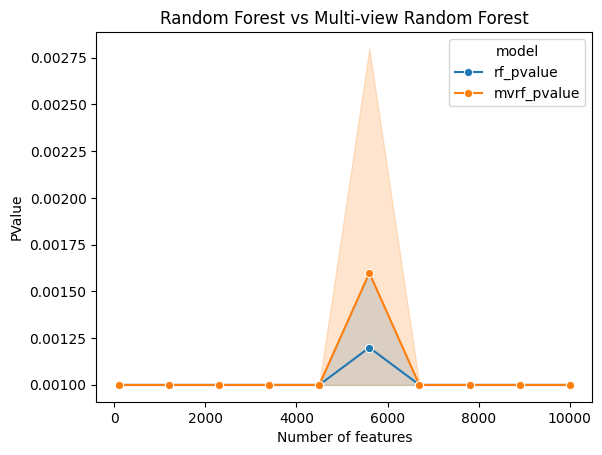

In [60]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("PValue")
ax.set_xlabel("Number of features")
ax.set_title("Random Forest vs Multi-view Random Forest")
plt.show()

## Correlated Views via latent factor model

In [78]:
n_views = 2
n_features = 100
n_samples = 500
joint_rank = 2

In [79]:
n_features_2_list = np.linspace(800, 10_000 - 200, 10, dtype=int)
n_features_2_list = np.insert(n_features_2_list, 0, 0)
print(n_features_2_list)
print(n_repeats)

[   0  800 1800 2800 3800 4800 5800 6800 7800 8800 9800]
5


In [70]:
Xs = make_joint_factor_model(
    n_views,
    n_features,
    n_samples=n_samples,
    joint_rank=joint_rank,
    noise_std=1,
    m=1.5,
    random_state=seed + idx,
    return_decomp=False,
)
n_features_1 = Xs[0].shape[1]
n_features_2 = Xs[1].shape[1]
signal_X = np.hstack(Xs)

print(signal_X.shape, n_features_1, n_features_2, [x.shape for x in Xs])
y = rng.binomial(
    n=1, p=expit(Xs[0][:, :10].sum(axis=1)), size=n_samples
) * rng.binomial(n=1, p=expit(Xs[1][:, :10].sum(axis=1)), size=n_samples)

n_features_ends = [n_features_1 + noise_dims, signal_X.shape[1]]

X = signal_X

(500, 2000) 1000 1000 [(500, 1000), (500, 1000)]


In [71]:
est = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        tree_estimator=MultiViewDecisionTreeClassifier(
            feature_set_ends=n_features_ends,
            apply_max_features_per_feature_set=True,
        ),
        random_state=seed,
        honest_fraction=0.5,
        n_jobs=n_jobs,
    ),
    random_state=seed,
    test_size=test_size,
    permute_per_tree=False,
    sample_dataset_per_tree=False,
)

est_mv_old = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        tree_estimator=MultiViewDecisionTreeClassifier(
            feature_set_ends=n_features_ends,
            apply_max_features_per_feature_set=False,
        ),
        random_state=seed,
        honest_fraction=0.5,
        n_jobs=n_jobs,
    ),
    random_state=seed,
    test_size=test_size,
    permute_per_tree=False,
    sample_dataset_per_tree=False,
)

est_rf = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        tree_estimator=DecisionTreeClassifier(),
        # tree_estimator=skDecisionTreeClassifier(),
        random_state=seed,
        honest_fraction=0.5,
        n_jobs=n_jobs,
    ),
    random_state=seed,
    test_size=test_size,
    permute_per_tree=False,
    sample_dataset_per_tree=False,
)

# compute the statistic and pvalue when we permute the first feature-set
covariate_index = np.arange(0, n_features_ends[0])
# print(covariate_index)
stat, pvalue = est.test(
    X,
    y,
    covariate_index=covariate_index,
    metric="mi",
    n_repeats=1000,
    # max_fpr=max_fpr
)
stat_old, pvalue_old = est_mv_old.test(
    X,
    y,
    covariate_index=covariate_index,
    metric="mi",
    n_repeats=1000,
    # max_fpr=max_fpr
)
stat_rf, pvalue_rf = est_rf.test(
    X,
    y,
    metric="mi",
    n_repeats=1000,
    # max_fpr=max_fpr
)

print(stat, stat_rf, stat_old)
print(pvalue, pvalue_rf, pvalue_old)

-0.004022479571626936 -0.0033975504885096486 -0.0034446304972344244
0.18081918081918083 0.15184815184815184 0.5344655344655345


In [107]:
print(n_features_2_list)
print(n_repeats)
print(max_features)

n_repeats = 100
# max_features = "sqrt"
print(max_features)

[   0  800 1800 2800 3800 4800 5800 6800 7800 8800 9800]
100
sqrt
sqrt


In [108]:
print(np.sqrt(1000), np.sqrt(100) + np.sqrt(900))

31.622776601683793 40.0


In [100]:
results = defaultdict(list)

for idx in range(n_repeats):
    Xs = make_joint_factor_model(
        n_views,
        n_features,
        n_samples=n_samples,
        joint_rank=joint_rank,
        noise_std=1,
        m=1.5,
        random_state=seed + idx,
        return_decomp=False,
    )
    n_features_1 = Xs[0].shape[1]
    n_features_2 = Xs[1].shape[1]
    signal_X = np.hstack(Xs)

    # print(signal_X.shape, n_features_1, n_features_2, [x.shape for x in Xs])
    y = rng.binomial(
        n=1, p=expit(Xs[0][:, :10].sum(axis=1)), size=n_samples
    ) * rng.binomial(n=1, p=expit(Xs[1][:, :10].sum(axis=1)), size=n_samples)

    n_features_ends = [n_features_1 + noise_dims, signal_X.shape[1]]

    for n_features_2_ in n_features_2_list:
        _X = np.hstack((signal_X, rng.standard_normal(size=(n_samples, n_features_2_))))
        X = _X.copy()
        n_features_ends[1] = X.shape[1]

        print(X.shape)

        # compute the statistic and pvalue when we permute the first feature-set
        covariate_index = np.arange(0, n_features_ends[0])
        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed + idx + n_features_2_,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        est_rf = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=DecisionTreeClassifier(),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed + idx + n_features_2_,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        stat, pvalue = est.test(
            X,
            y,
            covariate_index=covariate_index,
            metric="mi",
            # max_fpr=max_fpr
        )
        stat_rf, pvalue_rf = est_rf.test(
            X,
            y,
            covariate_index=covariate_index,
            metric="mi",
            # max_fpr=max_fpr
        )

        print(stat, stat_rf)
        print(pvalue, pvalue_rf)

        results["rf"].append(stat_rf)
        results["mvrf"].append(stat)
        results["rf_pvalue"].append(pvalue_rf)
        results["mvrf_pvalue"].append(pvalue)
        results["n_samples"].append(n_samples)
        results["n_features"].append(n_features_2_)

(500, 200)
-0.002655458458852067 -0.003449860801926996
0.4155844155844156 0.6603396603396603
(500, 1000)
-0.0017736270945367671 -0.0005057750354188206
0.2777222777222777 0.2077922077922078
(500, 2000)
-0.0013462699102650966 -0.002616255011827495
0.5354645354645354 0.7532467532467533
(500, 3000)
-0.002498312902666111 -0.004700353492522957
0.3706293706293706 0.5594405594405595
(500, 4000)
-0.004499822255106922 -0.0008928432259290853
0.7122877122877123 0.5114885114885115
(500, 5000)
-0.0025813271766376156 -0.0017144935503419223
0.45454545454545453 0.4595404595404595
(500, 6000)
-0.0034075609650673355 -0.0013967133459449332
0.8131868131868132 0.33166833166833165
(500, 7000)
-0.0032775113202173634 -0.0032564472338504347
0.4125874125874126 0.6193806193806194
(500, 8000)
-0.0016867825076238852 -0.0034270428056911717
0.1258741258741259 0.5154845154845155
(500, 9000)
-0.0027113601981156865 -0.0015188550969221781
0.4875124875124875 0.5614385614385614
(500, 10000)
-0.0022197692443474137 -0.003687

In [103]:
print(n_features_ends, X.shape)

[180, 10000] (500, 10000)


In [102]:
df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_pvalues_mi_mv_vs_rf_correlated_latentfactor_model.csv")

print(df.columns)
df.drop("rf", axis=1, inplace=True)
df.drop("mvrf", axis=1, inplace=True)

Index(['rf', 'mvrf', 'rf_pvalue', 'mvrf_pvalue', 'n_samples', 'n_features'], dtype='object')


In [105]:
# melt the dataframe, to make it easier to plot
df = pd.melt(
    df,
    id_vars=["n_features", "n_samples"],
    var_name="model",
    value_name="score",
)

In [104]:
display(df.head())

,rf_pvalue,mvrf_pvalue,n_samples,n_features
0,0.660340,0.415584,500,0
1,0.207792,0.277722,500,800
2,0.753247,0.535465,500,1800
3,0.559441,0.370629,500,2800
4,0.511489,0.712288,500,3800


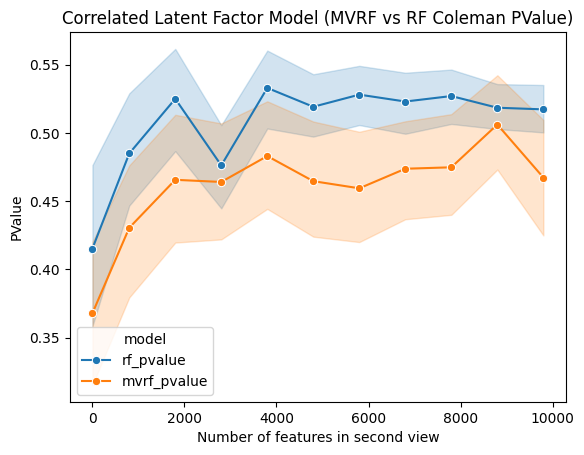

In [109]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("PValue")
ax.set_xlabel("Number of features in second view")
ax.set_title("Correlated Latent Factor Model (MVRF vs RF Coleman PValue)")
plt.show()

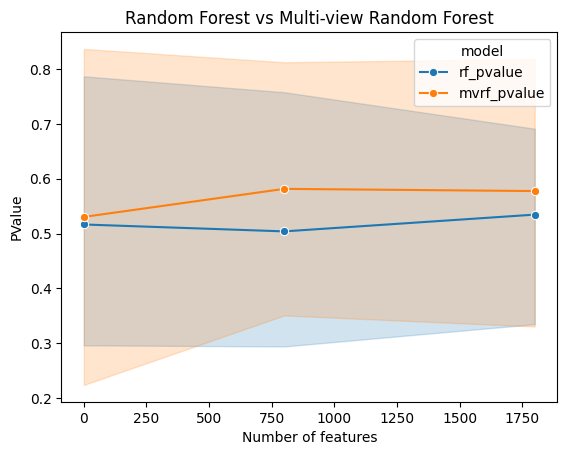

In [98]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("PValue")
ax.set_xlabel("Number of features")
ax.set_title("Random Forest vs Multi-view Random Forest")
plt.show()

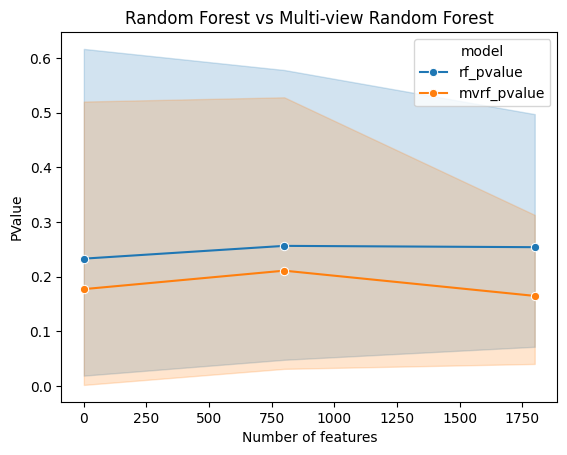

In [90]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("PValue")
ax.set_xlabel("Number of features")
ax.set_title("Random Forest vs Multi-view Random Forest")
plt.show()

## Data-generating model with views correlated by a direct effect

In [5]:
n_samples = 500
noise_dims = 80
n_features = 100 - noise_dims
n_features_2 = 10000 - noise_dims

n_repeats = 5

In [6]:
class_probs = [0.75, 0.25]

In [7]:
def make_multiview_dataset(
    n_features=50,
    n_features_2=50,
    noise_dims=50,
    n_samples=100,
    seed=None,
    transform="linear",
    class_probs=None,
):
    fixed_center = rng.standard_normal(size=(n_features,))
    # centers = [
    #     rng.standard_normal(size=(n_features,)),
    #     rng.standard_normal(size=(n_features,)),
    # ]
    centers = [fixed_center, fixed_center]

    covariances = [
        make_spd_matrix(n_dim=n_features, random_state=seed),
        make_spd_matrix(n_dim=n_features, random_state=seed + 123),
    ]

    # covariances = [
    #     make_sparse_spd_matrix(n_features, random_state=seed),
    #     make_sparse_spd_matrix(n_features, random_state=seed + 123),
    # ]

    Xs, y = make_gaussian_mixture(
        centers,
        covariances,
        n_samples=n_samples,
        noise=1.0,
        noise_dims=noise_dims,
        shuffle=True,
        class_probs=class_probs,
    )

    X = np.hstack(
        (Xs[1], Xs[0], rng.standard_normal(size=(n_samples, n_features_2 - n_features)))
    )
    n_features_ends = [
        n_features + noise_dims,
        n_features_2 + n_features + noise_dims * 2,
    ]
    return X, y, n_features_ends

In [11]:
X, y, n_features_ends = make_multiview_dataset(
    n_features=n_features,
    n_features_2=n_features_2,
    noise_dims=noise_dims,
    n_samples=n_samples,
    seed=seed,
    transform="sin",
    class_probs=class_probs,
)
print(X.shape)

est = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        tree_estimator=MultiViewDecisionTreeClassifier(
            feature_set_ends=n_features_ends,
            apply_max_features_per_feature_set=True,
        ),
        random_state=seed,
        honest_fraction=0.5,
        n_jobs=n_jobs,
    ),
    random_state=seed,
    test_size=test_size,
    permute_per_tree=False,
    sample_dataset_per_tree=False,
)

est_rf = FeatureImportanceForestClassifier(
    estimator=HonestForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        tree_estimator=DecisionTreeClassifier(),
        random_state=seed,
        honest_fraction=0.5,
        n_jobs=n_jobs,
    ),
    random_state=seed,
    test_size=test_size,
    permute_per_tree=False,
    sample_dataset_per_tree=False,
)

# compute the statistic and pvalue when we permute the first feature-set
covariate_index = np.arange(0, n_features_ends[0])
stat, pvalue = est.test(
    X, y, covariate_index=covariate_index, metric="auc", max_fpr=max_fpr
)
stat_rf, pvalue_rf = est_rf.test(X, y, metric="auc", max_fpr=max_fpr)

print(stat, stat_rf)
print(pvalue, pvalue_rf)

(500, 10100)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
0.6659649122807018 0.5677192982456141
0.000999000999000999 0.0919080919080919


In [42]:
n_features_2_list = np.linspace(500 - noise_dims, 10_000 - noise_dims, 10, dtype=int)
print(n_features_2_list)

[ 420 1475 2531 3586 4642 5697 6753 7808 8864 9920]


In [43]:
results = defaultdict(list)


for idx in range(n_repeats):
    n_features_begin = 0
    X = np.empty((n_samples, 0))
    y = np.empty((n_samples, 0))

    for n_features_2_ in n_features_2_list:
        _X, _y, n_features_ends = make_multiview_dataset(
            n_features=n_features,
            n_features_2=n_features_2_,
            noise_dims=noise_dims,
            n_samples=n_samples,
            seed=seed + idx + n_features_2_,
            transform="sin",
            class_probs=class_probs,
        )
        # stack features
        # print(X.shape, _X.shape)
        X = _X
        y = _y
        # X = np.hstack((X, _X[:, n_features_begin:]))
        # y = _y.copy()
        # n_features_begin = X.shape[1]

        print(
            "New dataset: ",
            n_features_2_,
            n_features_ends,
            X.shape,
            y.shape,
            n_features_begin,
        )

        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        est_rf = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=DecisionTreeClassifier(),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        # compute the statistic
        stat = est.statistic(X, y, metric="auc", max_fpr=max_fpr)
        stat_rf = est_rf.statistic(X, y, metric="auc", max_fpr=max_fpr)

        results["rf"].append(stat_rf)
        results["mvrf"].append(stat)
        results["n_samples"].append(n_samples)
        results["n_features_2"].append(n_features_2_)
        results["noise_dims"].append(noise_dims)
    # break

New dataset:  420 [100, 600] (500, 600) (500,) 0
New dataset:  1475 [100, 1655] (500, 1655) (500,) 0
New dataset:  2531 [100, 2711] (500, 2711) (500,) 0
New dataset:  3586 [100, 3766] (500, 3766) (500,) 0
New dataset:  4642 [100, 4822] (500, 4822) (500,) 0
New dataset:  5697 [100, 5877] (500, 5877) (500,) 0
New dataset:  6753 [100, 6933] (500, 6933) (500,) 0
New dataset:  7808 [100, 7988] (500, 7988) (500,) 0
New dataset:  8864 [100, 9044] (500, 9044) (500,) 0
New dataset:  9920 [100, 10100] (500, 10100) (500,) 0
New dataset:  420 [100, 600] (500, 600) (500,) 0
New dataset:  1475 [100, 1655] (500, 1655) (500,) 0
New dataset:  2531 [100, 2711] (500, 2711) (500,) 0
New dataset:  3586 [100, 3766] (500, 3766) (500,) 0
New dataset:  4642 [100, 4822] (500, 4822) (500,) 0
New dataset:  5697 [100, 5877] (500, 5877) (500,) 0
New dataset:  6753 [100, 6933] (500, 6933) (500,) 0
New dataset:  7808 [100, 7988] (500, 7988) (500,) 0
New dataset:  8864 [100, 9044] (500, 9044) (500,) 0
New dataset:  99

# Correlated views with direct/indirect effects on Y

In [114]:
n_features = 20
noise_dims = 80
max_features = 0.3

In [115]:
n_repeats = 100
n_estimators = 500

In [119]:
n_features_2_list = np.linspace(800, 10_000 - 200, 10, dtype=int)
n_features_2_list = np.insert(n_features_2_list, 0, 0)
print(n_features_2_list)

[   0  800 1800 2800 3800 4800 5800 6800 7800 8800 9800]


In [ ]:
results = defaultdict(list)

for idx in range(n_repeats):
    n_features_begin = 0
    fixed_center = rng.standard_normal(size=(n_features,))
    centers = [fixed_center, fixed_center]

    covariances = [
        make_spd_matrix(n_dim=n_features, random_state=seed),
        make_spd_matrix(n_dim=n_features, random_state=seed + 123),
    ]

    Xs, y = make_gaussian_mixture(
        centers,
        covariances,
        n_samples=n_samples,
        noise=1.0,
        noise_dims=noise_dims,
        shuffle=True,
        class_probs=class_probs,
        random_state=seed + idx,
    )

    signal_X = np.hstack((Xs[1], Xs[0]))
    n_features_ends = [
        n_features + noise_dims,
        n_features_2 + n_features + noise_dims * 2,
    ]
    # print(n_features_ends)

    for n_features_2_ in n_features_2_list:
        _X = np.hstack((signal_X, rng.standard_normal(size=(n_samples, n_features_2_))))
        X = _X.copy()
        n_features_ends[1] = X.shape[1]
        # print(X.shape, _X.shape)

        # print(
        #     "New dataset: ",
        #     n_features_2_,
        #     n_features_ends,
        #     X.shape,
        #     y.shape,
        #     n_features_begin,
        # )

        est = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=MultiViewDecisionTreeClassifier(
                    feature_set_ends=n_features_ends,
                    apply_max_features_per_feature_set=True,
                ),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        est_rf = FeatureImportanceForestClassifier(
            estimator=HonestForestClassifier(
                n_estimators=n_estimators,
                max_features=max_features,
                tree_estimator=DecisionTreeClassifier(),
                random_state=seed,
                honest_fraction=0.5,
                n_jobs=n_jobs,
            ),
            random_state=seed,
            test_size=test_size,
            permute_per_tree=False,
            sample_dataset_per_tree=False,
        )

        covariate_index = np.arange(0, n_features_ends[0])

        # compute the statistic
        stat, pvalue = est.test(X, y, covariate_index=covariate_index, metric="mi")
        stat_rf, pvalue_rf = est_rf.test(
            X, y, covariate_index=covariate_index, metric="mi"
        )

        print(stat, stat_rf)
        print(pvalue, pvalue_rf)

        results["rf"].append(stat_rf)
        results["mvrf"].append(stat)
        results["rf_pvalue"].append(pvalue_rf)
        results["mvrf_pvalue"].append(pvalue)
        results["n_samples"].append(n_samples)
        results["n_features"].append(n_features_2_)
    # break

0.042815277428301934 0.04127058657164728
0.000999000999000999 0.000999000999000999
0.031059067716403432 0.0264847897154199
0.000999000999000999 0.000999000999000999
0.02575619474594082 0.02402264771563145
0.000999000999000999 0.000999000999000999
0.02637989714715694 0.02320712886825893
0.000999000999000999 0.000999000999000999
0.022106280398163203 0.021727947451944396
0.000999000999000999 0.000999000999000999
0.021190239996741633 0.01836688489324645
0.000999000999000999 0.000999000999000999
0.020534677871865026 0.016538485137563397
0.000999000999000999 0.000999000999000999
0.022841573163217 0.015870520820076894
0.000999000999000999 0.000999000999000999
0.019503911607987146 0.018121661240735
0.000999000999000999 0.000999000999000999
0.020622384551662543 0.01900116599632551
0.000999000999000999 0.000999000999000999
0.017944363696968946 0.016432890880229367
0.000999000999000999 0.000999000999000999
0.051251358565805316 0.04998920255304562
0.000999000999000999 0.000999000999000999
0.048237

In [ ]:
print("done")

In [ ]:
print(n_features_ends, X.shape)

In [ ]:
df = pd.DataFrame(results)

# save the results
df.to_csv("./cv_pvalues_mi_mv_vs_rf_directindirecteffects_model.csv")

print(df.columns)
df.drop("rf", axis=1, inplace=True)
df.drop("mvrf", axis=1, inplace=True)

In [ ]:
# melt the dataframe, to make it easier to plot
df = pd.melt(
    df,
    id_vars=["n_features", "n_samples"],
    var_name="model",
    value_name="score",
)

In [ ]:
display(df.head())

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x="n_features", y="score", marker="o", hue="model", ax=ax)
ax.set_ylabel("PValue")
ax.set_xlabel("Number of features in second view")
ax.set_title("Gaussian Mixture Model (with Transformation) (MVRF vs RF Coleman PValue)")
plt.show()